In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import logging
import sys

stdout = logging.StreamHandler(sys.stdout)
file = logging.FileHandler('./log/SimpleVAE.log')
logging.basicConfig(level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    handlers=[file,
                             stdout]
                    )
logging.info("------------------- logging start ----------------------")

2020-04-09 00:04:40,274 - INFO - ------------------- logging start ----------------------


In [ ]:
from PIL import Image
Display = lambda img_tensor: display(transforms.ToPILImage()(img_tensor).convert("RGB"))
SaveImg = lambda tensor, path:transforms.ToPILImage()(tensor).convert("RGB").save(path)

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
batch_size = 64
hidden = 512       # size of the latent vector
beta = 2          # hyperparameter for beta-VAE model
M_N = 1            # hyperparameter for beta-VAE model

In [75]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import SubsetRandomSampler
import random
from random import choices
random.seed(52)
data_transform = transforms.Compose([transforms.ToTensor(),])

your_name_dataset = ImageFolder(root="../png/142p_data",
                                transform=data_transform)
N = len(your_name_dataset)
sample_N = batch_size
# sample_indices = choices(list(range(1, N)), k=sample_N)
sample_indices = list(range(10000, 10600))

data_loader = torch.utils.data.DataLoader(your_name_dataset,
                                          shuffle=False,
                                          batch_size=batch_size,
                                          pin_memory=True,
                                          sampler=SubsetRandomSampler(sample_indices)
                                         )

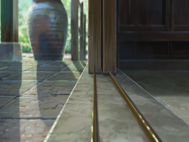

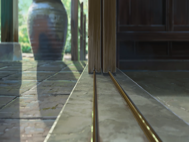

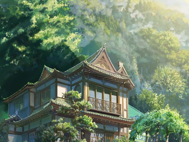

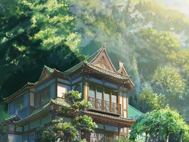

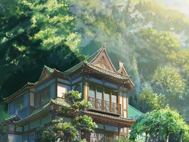

In [92]:
for i in range(5):
    Display(your_name_dataset[sample_indices[10+i]][0])

In [93]:
input_dim = your_name_dataset[0][0].reshape(-1, 1).size(0)
print(your_name_dataset[0][0].shape)
print(input_dim)

torch.Size([3, 142, 189])
80514


In [94]:
from torch.autograd import Variable
def _cal_dim(x, k, s, p=0):
    return (x - k + p) // s + 1
    
class View(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.view(self.dim)

class BetaVAE(nn.Module):
    def __init__(self, latent=10, in_channels=3):
        super().__init__()
        self.latent = latent
        self.in_channels = in_channels
        
        a, b = 2, 5
        # Adjust the kernel size based on our input size 142 x 189. In the paper, the input is 64 x 64.
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=(8, 9), stride=2),    # (B, -1, 142, 189)     
            nn.ReLU(True),
            nn.Conv2d(32, 32, kernel_size=(6, 7), stride=2),             # (B, -1, 68, 91)     
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=(6, 7), stride=2),             # (B, -1, 32, 43)   
            nn.ReLU(True),
            nn.Conv2d(64, 256, kernel_size=(6, 7), stride=2),            # (B, -1, 14, 19) 
            nn.ReLU(True),
            nn.Conv2d(256, 512, kernel_size=(5, 7), stride=1),     # (B, -1, 5, 7)        
            nn.ReLU(True),
            View((-1, 512 * 1 * 1))          
        )
        self.fc_mu = nn.Linear(512 * 1 * 1, latent)
        self.fc_sigma = nn.Linear(512 * 1 * 1, latent)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent, 512 * 1 * 1),             
            View((-1, 512, 1, 1)),              
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=(5, 7), stride=1),  
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 64, kernel_size=(6, 7), stride=2), 
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=(6, 7), stride=2), 
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 32, kernel_size=(6, 7), stride=2), 
            nn.ReLU(True),
            nn.ConvTranspose2d(32, in_channels, kernel_size=(8, 9), stride=2), 
        )


    def forward(self, x):
        batch_size = x.size(0)
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_sigma(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar
    

    def reparameterize(self, mu, logvar):
        std = logvar.div(2).exp()
        eps = Variable(torch.randn_like(std))
        return eps * std + mu


In [95]:
# x = _cal_dim(142, 8, 2)   # 68
# x = _cal_dim(x, 6, 2)     # 32
# x = _cal_dim(x, 6, 2)     # 14
# x = _cal_dim(x, 6, 2)     #  5
# x = _cal_dim(x, 5, 1)
# print(x)

In [96]:
# x = _cal_dim(189, 9, 2)  # 91
# x = _cal_dim(x, 7, 2)     # 43
# x = _cal_dim(x, 7, 2) # 19
# x = _cal_dim(x, 7, 2) # 7
# x = _cal_dim(x, 7, 1)
# print(x)

In [97]:
def loss_function(recon_x, x, mu, logvar):
    b = x.size(0)
    recon_x, x = recon_x.view(b, -1), x.view(b, -1)
    recon_x = torch.sigmoid(recon_x)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Varational Bayes. ICLR,i 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss, KLD

In [98]:
from torchsummary import summary

In [100]:
# torch.cuda.empty_cache()
# torch.cuda.memory_summary()

In [102]:
model = BetaVAE(latent=hidden)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# scheduler = optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=1)

In [248]:
summary(model, (3, 142, 189))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 68, 91]           6,944
              ReLU-2           [-1, 32, 68, 91]               0
            Conv2d-3           [-1, 32, 32, 43]          43,040
              ReLU-4           [-1, 32, 32, 43]               0
            Conv2d-5           [-1, 64, 14, 19]          86,080
              ReLU-6           [-1, 64, 14, 19]               0
            Conv2d-7            [-1, 256, 5, 7]         688,384
              ReLU-8            [-1, 256, 5, 7]               0
            Conv2d-9            [-1, 512, 1, 1]       4,588,032
             ReLU-10            [-1, 512, 1, 1]               0
             View-11                  [-1, 512]               0
           Linear-12                  [-1, 512]         262,656
           Linear-13                  [-1, 512]         262,656
           Linear-14                  [

In [103]:
# torch.save(model.state_dict(), "./state/VAE.state")
# model.load_state_dict(torch.load("./state/VAE.state"))

In [104]:
# scheduler = optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=1)

In [105]:
# scheduler.step()

In [106]:
epochs = 2000
log_interval = 20
length = len(data_loader) // batch_size +1

for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(data_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss1, loss2 = loss_function(recon_batch, data, mu, logvar)
        print(f"loss1={loss1}, loss2={loss2}")
        loss = loss1 + beta * M_N * loss2
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % length == 0:
            logging.info('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx, len(data_loader),
                100. * batch_idx / len(data_loader),
                loss.item()))

    logging.info('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss * batch_size / len(data_loader)))
    


loss1=263611.75, loss2=16.68915557861328
2020-04-09 00:51:45,885 - INFO - Train Epoch: 1 [0/10 (0%)]	Loss: 263645.125000
loss1=274289.78125, loss2=19.913188934326172
2020-04-09 00:51:48,962 - INFO - Train Epoch: 1 [1/10 (10%)]	Loss: 274329.593750
loss1=267871.9375, loss2=11.035406112670898
2020-04-09 00:51:51,791 - INFO - Train Epoch: 1 [2/10 (20%)]	Loss: 267894.000000
loss1=278734.1875, loss2=6.1502685546875
2020-04-09 00:51:54,728 - INFO - Train Epoch: 1 [3/10 (30%)]	Loss: 278746.500000
loss1=256903.421875, loss2=4.395918846130371
2020-04-09 00:51:57,422 - INFO - Train Epoch: 1 [4/10 (40%)]	Loss: 256912.218750
loss1=265854.9375, loss2=5.685374736785889
2020-04-09 00:52:00,318 - INFO - Train Epoch: 1 [5/10 (50%)]	Loss: 265866.312500
loss1=241901.21875, loss2=11.001726150512695
2020-04-09 00:52:03,041 - INFO - Train Epoch: 1 [6/10 (60%)]	Loss: 241923.218750
loss1=257340.984375, loss2=8.666759490966797
2020-04-09 00:52:05,951 - INFO - Train Epoch: 1 [7/10 (70%)]	Loss: 257358.312500
loss

2020-04-09 00:52:25,245 - INFO - Train Epoch: 7 [2/10 (20%)]	Loss: 222015.765625
loss1=222120.0, loss2=855.2152709960938
2020-04-09 00:52:25,551 - INFO - Train Epoch: 7 [3/10 (30%)]	Loss: 223830.437500
loss1=209470.953125, loss2=898.9688720703125
2020-04-09 00:52:25,862 - INFO - Train Epoch: 7 [4/10 (40%)]	Loss: 211268.890625
loss1=202900.828125, loss2=1158.740478515625
2020-04-09 00:52:26,168 - INFO - Train Epoch: 7 [5/10 (50%)]	Loss: 205218.312500
loss1=213616.65625, loss2=1102.7860107421875
2020-04-09 00:52:26,476 - INFO - Train Epoch: 7 [6/10 (60%)]	Loss: 215822.234375
loss1=206278.078125, loss2=695.155029296875
2020-04-09 00:52:26,780 - INFO - Train Epoch: 7 [7/10 (70%)]	Loss: 207668.390625
loss1=225233.25, loss2=884.4020385742188
2020-04-09 00:52:27,087 - INFO - Train Epoch: 7 [8/10 (80%)]	Loss: 227002.046875
loss1=70093.453125, loss2=395.371826171875
2020-04-09 00:52:27,224 - INFO - Train Epoch: 7 [9/10 (90%)]	Loss: 70884.195312
2020-04-09 00:52:27,225 - INFO - ====> Epoch: 7 Av

2020-04-09 00:52:43,212 - INFO - Train Epoch: 13 [4/10 (40%)]	Loss: 162647.250000
loss1=160233.34375, loss2=1322.434814453125
2020-04-09 00:52:43,520 - INFO - Train Epoch: 13 [5/10 (50%)]	Loss: 162878.218750
loss1=165930.5, loss2=1274.59912109375
2020-04-09 00:52:43,832 - INFO - Train Epoch: 13 [6/10 (60%)]	Loss: 168479.703125
loss1=157042.125, loss2=1641.431640625
2020-04-09 00:52:44,145 - INFO - Train Epoch: 13 [7/10 (70%)]	Loss: 160324.984375
loss1=162692.96875, loss2=2104.444091796875
2020-04-09 00:52:44,453 - INFO - Train Epoch: 13 [8/10 (80%)]	Loss: 166901.859375
loss1=62869.109375, loss2=545.15283203125
2020-04-09 00:52:44,592 - INFO - Train Epoch: 13 [9/10 (90%)]	Loss: 63959.414062
2020-04-09 00:52:44,593 - INFO - ====> Epoch: 13 Average loss: 9745547.4500
loss1=157447.921875, loss2=1904.30859375
2020-04-09 00:52:44,899 - INFO - Train Epoch: 14 [0/10 (0%)]	Loss: 161256.531250
loss1=147059.203125, loss2=2803.326171875
2020-04-09 00:52:45,208 - INFO - Train Epoch: 14 [1/10 (10%)]

loss1=116306.84375, loss2=2446.190185546875
2020-04-09 00:53:01,610 - INFO - Train Epoch: 19 [7/10 (70%)]	Loss: 121199.226562
loss1=110772.7109375, loss2=2277.202880859375
2020-04-09 00:53:01,918 - INFO - Train Epoch: 19 [8/10 (80%)]	Loss: 115327.117188
loss1=44993.01171875, loss2=1244.68603515625
2020-04-09 00:53:02,055 - INFO - Train Epoch: 19 [9/10 (90%)]	Loss: 47482.382812
2020-04-09 00:53:02,056 - INFO - ====> Epoch: 19 Average loss: 7225083.9000
loss1=113312.4921875, loss2=2543.01220703125
2020-04-09 00:53:02,364 - INFO - Train Epoch: 20 [0/10 (0%)]	Loss: 118398.515625
loss1=113957.0859375, loss2=2301.46728515625
2020-04-09 00:53:02,672 - INFO - Train Epoch: 20 [1/10 (10%)]	Loss: 118560.023438
loss1=113858.453125, loss2=2455.4970703125
2020-04-09 00:53:02,980 - INFO - Train Epoch: 20 [2/10 (20%)]	Loss: 118769.445312
loss1=111696.03125, loss2=2743.3017578125
2020-04-09 00:53:03,286 - INFO - Train Epoch: 20 [3/10 (30%)]	Loss: 117182.632812
loss1=109678.6484375, loss2=2380.40625
202

loss1=38576.234375, loss2=882.945556640625
2020-04-09 00:53:19,566 - INFO - Train Epoch: 25 [9/10 (90%)]	Loss: 40342.125000
2020-04-09 00:53:19,567 - INFO - ====> Epoch: 25 Average loss: 6101245.2000
loss1=91279.1796875, loss2=2851.1328125
2020-04-09 00:53:19,881 - INFO - Train Epoch: 26 [0/10 (0%)]	Loss: 96981.445312
loss1=96788.875, loss2=2919.80419921875
2020-04-09 00:53:20,193 - INFO - Train Epoch: 26 [1/10 (10%)]	Loss: 102628.484375
loss1=84551.4765625, loss2=3126.493408203125
2020-04-09 00:53:20,504 - INFO - Train Epoch: 26 [2/10 (20%)]	Loss: 90804.460938
loss1=92431.3671875, loss2=2876.540771484375
2020-04-09 00:53:20,809 - INFO - Train Epoch: 26 [3/10 (30%)]	Loss: 98184.445312
loss1=97805.8984375, loss2=2541.832275390625
2020-04-09 00:53:21,116 - INFO - Train Epoch: 26 [4/10 (40%)]	Loss: 102889.562500
loss1=82423.375, loss2=3020.70947265625
2020-04-09 00:53:21,424 - INFO - Train Epoch: 26 [5/10 (50%)]	Loss: 88464.796875
loss1=96657.875, loss2=2532.283203125
2020-04-09 00:53:21,

2020-04-09 00:53:37,729 - INFO - Train Epoch: 32 [1/10 (10%)]	Loss: 84914.007812
loss1=76668.796875, loss2=2409.208251953125
2020-04-09 00:53:38,038 - INFO - Train Epoch: 32 [2/10 (20%)]	Loss: 81487.210938
loss1=76314.65625, loss2=2840.07275390625
2020-04-09 00:53:38,351 - INFO - Train Epoch: 32 [3/10 (30%)]	Loss: 81994.804688
loss1=71799.1640625, loss2=2753.477783203125
2020-04-09 00:53:38,662 - INFO - Train Epoch: 32 [4/10 (40%)]	Loss: 77306.117188
loss1=73378.421875, loss2=2454.10205078125
2020-04-09 00:53:38,975 - INFO - Train Epoch: 32 [5/10 (50%)]	Loss: 78286.625000
loss1=73778.703125, loss2=2803.41552734375
2020-04-09 00:53:39,285 - INFO - Train Epoch: 32 [6/10 (60%)]	Loss: 79385.531250
loss1=76604.359375, loss2=2803.026123046875
2020-04-09 00:53:39,595 - INFO - Train Epoch: 32 [7/10 (70%)]	Loss: 82210.414062
loss1=73562.3203125, loss2=2535.8564453125
2020-04-09 00:53:39,899 - INFO - Train Epoch: 32 [8/10 (80%)]	Loss: 78634.031250
loss1=30841.03515625, loss2=838.3834228515625
20

2020-04-09 00:53:56,235 - INFO - Train Epoch: 38 [4/10 (40%)]	Loss: 77439.695312
loss1=65712.3515625, loss2=3010.4873046875
2020-04-09 00:53:56,544 - INFO - Train Epoch: 38 [5/10 (50%)]	Loss: 71733.328125
loss1=63502.89453125, loss2=3324.90234375
2020-04-09 00:53:56,854 - INFO - Train Epoch: 38 [6/10 (60%)]	Loss: 70152.703125
loss1=64304.296875, loss2=3193.64794921875
2020-04-09 00:53:57,163 - INFO - Train Epoch: 38 [7/10 (70%)]	Loss: 70691.593750
loss1=72538.1875, loss2=3219.777099609375
2020-04-09 00:53:57,469 - INFO - Train Epoch: 38 [8/10 (80%)]	Loss: 78977.742188
loss1=24527.703125, loss2=1016.1990966796875
2020-04-09 00:53:57,607 - INFO - Train Epoch: 38 [9/10 (90%)]	Loss: 26560.101562
2020-04-09 00:53:57,608 - INFO - ====> Epoch: 38 Average loss: 4488277.5500
loss1=68550.546875, loss2=2996.84814453125
2020-04-09 00:53:57,916 - INFO - Train Epoch: 39 [0/10 (0%)]	Loss: 74544.242188
loss1=58340.4296875, loss2=3281.415771484375
2020-04-09 00:53:58,225 - INFO - Train Epoch: 39 [1/10 

loss1=60681.3671875, loss2=2601.485107421875
2020-04-09 00:54:14,739 - INFO - Train Epoch: 44 [7/10 (70%)]	Loss: 65884.335938
loss1=63164.9375, loss2=2688.0146484375
2020-04-09 00:54:15,045 - INFO - Train Epoch: 44 [8/10 (80%)]	Loss: 68540.968750
loss1=24140.51953125, loss2=1009.4678955078125
2020-04-09 00:54:15,181 - INFO - Train Epoch: 44 [9/10 (90%)]	Loss: 26159.455078
2020-04-09 00:54:15,182 - INFO - ====> Epoch: 44 Average loss: 4092949.1375
loss1=66851.921875, loss2=2534.4716796875
2020-04-09 00:54:15,487 - INFO - Train Epoch: 45 [0/10 (0%)]	Loss: 71920.867188
loss1=63050.2109375, loss2=2748.20654296875
2020-04-09 00:54:15,799 - INFO - Train Epoch: 45 [1/10 (10%)]	Loss: 68546.625000
loss1=54713.71484375, loss2=2949.234375
2020-04-09 00:54:16,111 - INFO - Train Epoch: 45 [2/10 (20%)]	Loss: 60612.183594
loss1=52300.17578125, loss2=2924.21728515625
2020-04-09 00:54:16,419 - INFO - Train Epoch: 45 [3/10 (30%)]	Loss: 58148.609375
loss1=65917.0625, loss2=2861.26806640625
2020-04-09 00:

2020-04-09 00:54:32,698 - INFO - ====> Epoch: 50 Average loss: 3715742.7375
loss1=51095.171875, loss2=2948.0537109375
2020-04-09 00:54:33,004 - INFO - Train Epoch: 51 [0/10 (0%)]	Loss: 56991.281250
loss1=56823.234375, loss2=2878.8349609375
2020-04-09 00:54:33,316 - INFO - Train Epoch: 51 [1/10 (10%)]	Loss: 62580.906250
loss1=56112.078125, loss2=3170.226806640625
2020-04-09 00:54:33,624 - INFO - Train Epoch: 51 [2/10 (20%)]	Loss: 62452.531250
loss1=56841.109375, loss2=3064.10205078125
2020-04-09 00:54:33,928 - INFO - Train Epoch: 51 [3/10 (30%)]	Loss: 62969.312500
loss1=60276.40625, loss2=2951.203857421875
2020-04-09 00:54:34,236 - INFO - Train Epoch: 51 [4/10 (40%)]	Loss: 66178.812500
loss1=54600.62109375, loss2=2920.7060546875
2020-04-09 00:54:34,549 - INFO - Train Epoch: 51 [5/10 (50%)]	Loss: 60442.031250
loss1=56889.75, loss2=2916.73388671875
2020-04-09 00:54:34,861 - INFO - Train Epoch: 51 [6/10 (60%)]	Loss: 62723.218750
loss1=54292.3203125, loss2=2844.488525390625
2020-04-09 00:54

loss1=49861.8671875, loss2=3230.095947265625
2020-04-09 00:54:51,173 - INFO - Train Epoch: 57 [2/10 (20%)]	Loss: 56322.058594
loss1=47362.75, loss2=3076.38134765625
2020-04-09 00:54:51,482 - INFO - Train Epoch: 57 [3/10 (30%)]	Loss: 53515.511719
loss1=52513.6953125, loss2=3042.19384765625
2020-04-09 00:54:51,791 - INFO - Train Epoch: 57 [4/10 (40%)]	Loss: 58598.082031
loss1=51935.390625, loss2=2754.724365234375
2020-04-09 00:54:52,103 - INFO - Train Epoch: 57 [5/10 (50%)]	Loss: 57444.839844
loss1=56577.44921875, loss2=2763.0771484375
2020-04-09 00:54:52,413 - INFO - Train Epoch: 57 [6/10 (60%)]	Loss: 62103.601562
loss1=53184.1640625, loss2=2892.18212890625
2020-04-09 00:54:52,725 - INFO - Train Epoch: 57 [7/10 (70%)]	Loss: 58968.527344
loss1=51562.8828125, loss2=2695.661376953125
2020-04-09 00:54:53,034 - INFO - Train Epoch: 57 [8/10 (80%)]	Loss: 56954.207031
loss1=20365.19140625, loss2=1139.178466796875
2020-04-09 00:54:53,171 - INFO - Train Epoch: 57 [9/10 (90%)]	Loss: 22643.548828
2

2020-04-09 00:55:09,344 - INFO - Train Epoch: 63 [4/10 (40%)]	Loss: 60033.792969
loss1=50973.34375, loss2=3050.958984375
2020-04-09 00:55:09,656 - INFO - Train Epoch: 63 [5/10 (50%)]	Loss: 57075.261719
loss1=49438.5390625, loss2=2980.925537109375
2020-04-09 00:55:09,969 - INFO - Train Epoch: 63 [6/10 (60%)]	Loss: 55400.390625
loss1=50936.6484375, loss2=3120.7451171875
2020-04-09 00:55:10,282 - INFO - Train Epoch: 63 [7/10 (70%)]	Loss: 57178.140625
loss1=53002.79296875, loss2=3155.36962890625
2020-04-09 00:55:10,594 - INFO - Train Epoch: 63 [8/10 (80%)]	Loss: 59313.531250
loss1=19458.89453125, loss2=1174.5269775390625
2020-04-09 00:55:10,737 - INFO - Train Epoch: 63 [9/10 (90%)]	Loss: 21807.949219
2020-04-09 00:55:10,737 - INFO - ====> Epoch: 63 Average loss: 3352020.2500
loss1=48040.90625, loss2=3068.89306640625
2020-04-09 00:55:11,050 - INFO - Train Epoch: 64 [0/10 (0%)]	Loss: 54178.691406
loss1=53656.98828125, loss2=3109.5791015625
2020-04-09 00:55:11,362 - INFO - Train Epoch: 64 [1/

loss1=49126.4765625, loss2=3116.93994140625
2020-04-09 00:55:28,115 - INFO - Train Epoch: 69 [7/10 (70%)]	Loss: 55360.355469
loss1=50750.32421875, loss2=2945.80712890625
2020-04-09 00:55:28,431 - INFO - Train Epoch: 69 [8/10 (80%)]	Loss: 56641.937500
loss1=19324.41015625, loss2=1189.781982421875
2020-04-09 00:55:28,570 - INFO - Train Epoch: 69 [9/10 (90%)]	Loss: 21703.974609
2020-04-09 00:55:28,571 - INFO - ====> Epoch: 69 Average loss: 3301749.5875
loss1=48634.3359375, loss2=3217.74169921875
2020-04-09 00:55:28,886 - INFO - Train Epoch: 70 [0/10 (0%)]	Loss: 55069.820312
loss1=53147.328125, loss2=3264.5224609375
2020-04-09 00:55:29,203 - INFO - Train Epoch: 70 [1/10 (10%)]	Loss: 59676.375000
loss1=48902.71484375, loss2=3466.223876953125
2020-04-09 00:55:29,520 - INFO - Train Epoch: 70 [2/10 (20%)]	Loss: 55835.164062
loss1=45585.8359375, loss2=3148.73681640625
2020-04-09 00:55:29,835 - INFO - Train Epoch: 70 [3/10 (30%)]	Loss: 51883.308594
loss1=47967.7109375, loss2=3531.43896484375
202

loss1=16230.359375, loss2=1080.3963623046875
2020-04-09 00:55:46,388 - INFO - Train Epoch: 75 [9/10 (90%)]	Loss: 18391.152344
2020-04-09 00:55:46,389 - INFO - ====> Epoch: 75 Average loss: 3166678.4500
loss1=46504.02734375, loss2=2791.5400390625
2020-04-09 00:55:46,706 - INFO - Train Epoch: 76 [0/10 (0%)]	Loss: 52087.109375
loss1=47974.5546875, loss2=3137.247802734375
2020-04-09 00:55:47,028 - INFO - Train Epoch: 76 [1/10 (10%)]	Loss: 54249.050781
loss1=47981.93359375, loss2=3053.925537109375
2020-04-09 00:55:47,343 - INFO - Train Epoch: 76 [2/10 (20%)]	Loss: 54089.785156
loss1=49072.203125, loss2=3148.66748046875
2020-04-09 00:55:47,654 - INFO - Train Epoch: 76 [3/10 (30%)]	Loss: 55369.539062
loss1=43417.66015625, loss2=3189.91845703125
2020-04-09 00:55:47,970 - INFO - Train Epoch: 76 [4/10 (40%)]	Loss: 49797.496094
loss1=46047.4140625, loss2=2986.02001953125
2020-04-09 00:55:48,286 - INFO - Train Epoch: 76 [5/10 (50%)]	Loss: 52019.453125
loss1=46630.65234375, loss2=3255.267333984375


loss1=41190.265625, loss2=2922.168701171875
2020-04-09 00:56:04,995 - INFO - Train Epoch: 82 [1/10 (10%)]	Loss: 47034.601562
loss1=46883.45703125, loss2=3187.62353515625
2020-04-09 00:56:05,315 - INFO - Train Epoch: 82 [2/10 (20%)]	Loss: 53258.703125
loss1=45627.95703125, loss2=2977.5791015625
2020-04-09 00:56:05,630 - INFO - Train Epoch: 82 [3/10 (30%)]	Loss: 51583.117188
loss1=45705.12109375, loss2=2901.169921875
2020-04-09 00:56:05,950 - INFO - Train Epoch: 82 [4/10 (40%)]	Loss: 51507.460938
loss1=41791.93359375, loss2=2702.85791015625
2020-04-09 00:56:06,271 - INFO - Train Epoch: 82 [5/10 (50%)]	Loss: 47197.648438
loss1=44909.0703125, loss2=2549.948486328125
2020-04-09 00:56:06,591 - INFO - Train Epoch: 82 [6/10 (60%)]	Loss: 50008.968750
loss1=45521.20703125, loss2=2560.014892578125
2020-04-09 00:56:06,910 - INFO - Train Epoch: 82 [7/10 (70%)]	Loss: 50641.238281
loss1=44538.2421875, loss2=2735.689453125
2020-04-09 00:56:07,224 - INFO - Train Epoch: 82 [8/10 (80%)]	Loss: 50009.62109

loss1=46863.796875, loss2=3046.02392578125
2020-04-09 00:56:24,216 - INFO - Train Epoch: 88 [4/10 (40%)]	Loss: 52955.843750
loss1=42278.6484375, loss2=3153.7412109375
2020-04-09 00:56:24,535 - INFO - Train Epoch: 88 [5/10 (50%)]	Loss: 48586.132812
loss1=45380.37109375, loss2=3114.1220703125
2020-04-09 00:56:24,852 - INFO - Train Epoch: 88 [6/10 (60%)]	Loss: 51608.617188
loss1=43878.4921875, loss2=2678.1689453125
2020-04-09 00:56:25,171 - INFO - Train Epoch: 88 [7/10 (70%)]	Loss: 49234.828125
loss1=45651.5859375, loss2=2794.6591796875
2020-04-09 00:56:25,491 - INFO - Train Epoch: 88 [8/10 (80%)]	Loss: 51240.906250
loss1=15601.82421875, loss2=942.3599243164062
2020-04-09 00:56:25,630 - INFO - Train Epoch: 88 [9/10 (90%)]	Loss: 17486.544922
2020-04-09 00:56:25,631 - INFO - ====> Epoch: 88 Average loss: 3018960.0875
loss1=44453.8671875, loss2=3085.67919921875
2020-04-09 00:56:25,947 - INFO - Train Epoch: 89 [0/10 (0%)]	Loss: 50625.226562
loss1=44303.4140625, loss2=2897.214599609375
2020-04

2020-04-09 00:56:43,017 - INFO - Train Epoch: 94 [6/10 (60%)]	Loss: 45694.570312
loss1=40394.4296875, loss2=3021.0283203125
2020-04-09 00:56:43,387 - INFO - Train Epoch: 94 [7/10 (70%)]	Loss: 46436.484375
loss1=43824.5390625, loss2=3126.08642578125
2020-04-09 00:56:43,710 - INFO - Train Epoch: 94 [8/10 (80%)]	Loss: 50076.710938
loss1=16370.4853515625, loss2=1033.51025390625
2020-04-09 00:56:43,851 - INFO - Train Epoch: 94 [9/10 (90%)]	Loss: 18437.505859
2020-04-09 00:56:43,852 - INFO - ====> Epoch: 94 Average loss: 2876240.1125
loss1=43700.296875, loss2=2904.96484375
2020-04-09 00:56:44,167 - INFO - Train Epoch: 95 [0/10 (0%)]	Loss: 49510.226562
loss1=42644.2578125, loss2=2928.293212890625
2020-04-09 00:56:44,478 - INFO - Train Epoch: 95 [1/10 (10%)]	Loss: 48500.843750
loss1=34283.6171875, loss2=2709.944580078125
2020-04-09 00:56:44,791 - INFO - Train Epoch: 95 [2/10 (20%)]	Loss: 39703.507812
loss1=40612.0703125, loss2=2559.16552734375
2020-04-09 00:56:45,105 - INFO - Train Epoch: 95 [

2020-04-09 00:57:01,866 - INFO - Train Epoch: 100 [8/10 (80%)]	Loss: 48857.500000
loss1=15104.61328125, loss2=1011.7093505859375
2020-04-09 00:57:02,007 - INFO - Train Epoch: 100 [9/10 (90%)]	Loss: 17128.031250
2020-04-09 00:57:02,008 - INFO - ====> Epoch: 100 Average loss: 2827972.7250
loss1=39913.13671875, loss2=2875.54833984375
2020-04-09 00:57:02,323 - INFO - Train Epoch: 101 [0/10 (0%)]	Loss: 45664.234375
loss1=39489.5546875, loss2=2744.62841796875
2020-04-09 00:57:02,638 - INFO - Train Epoch: 101 [1/10 (10%)]	Loss: 44978.812500
loss1=45089.390625, loss2=2904.220703125
2020-04-09 00:57:03,034 - INFO - Train Epoch: 101 [2/10 (20%)]	Loss: 50897.832031
loss1=42698.3125, loss2=2959.5478515625
2020-04-09 00:57:03,343 - INFO - Train Epoch: 101 [3/10 (30%)]	Loss: 48617.406250
loss1=40636.9921875, loss2=3372.99658203125
2020-04-09 00:57:03,655 - INFO - Train Epoch: 101 [4/10 (40%)]	Loss: 47382.984375
loss1=45761.1171875, loss2=3413.86181640625
2020-04-09 00:57:03,963 - INFO - Train Epoch:

KeyboardInterrupt: 

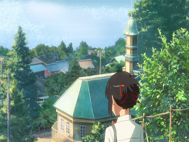

In [107]:
Display(data[3].cpu())

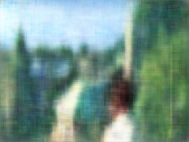

In [108]:
Display(torch.sigmoid(recon_batch[3].cpu()))

In [68]:
SaveImg(torch.sigmoid(recon_batch[2].cpu()), "./images/VAE_output1.png")
SaveImg(torch.sigmoid(recon_batch[3].cpu()), "./images/VAE_output2.png")

In [69]:
SaveImg(data[2].cpu(), "./images/VAE_input1.png")
SaveImg(data[3].cpu(), "./images/VAE_input2.png")

# Visualization of the KL loss.

In [ ]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions import kl_divergence
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

In [71]:
# load the model
model.load_state_dict(torch.load("./state/VAE.state"))

<All keys matched successfully>

In [73]:
d = iter(data_loader)
data, _ = next(d)

In [217]:
# indices = [sample_indices[10+i] for i in range(6)]
indices = sample_indices
data = torch.cat([your_name_dataset[i][0].unsqueeze(0) for i in indices], dim=0)
data = data.to(device)
recon_batch, mu, logvar = model(data)
loss1, kl_loss = loss_function(recon_batch, data, mu, logvar)

In [218]:
df = defaultdict(list)
for i in range(len(indices)-1):
    mean1 = mu[i]
    var1 = torch.diag(logvar[i].exp())
    d1 = MultivariateNormal(mean1, var1)
    mean2 = mu[i+1]
    var2 = torch.diag(logvar[i+1].exp())
    d2 = MultivariateNormal(mean2, var2)
    KL = kl_divergence(d1, d2)

    sample1 = data[i]
    sample2 = data[i+1]
    L2 = F.mse_loss(sample1, sample2, reduction="sum")
    L1 = F.l1_loss(sample1, sample2, reduction="sum")
    name = f"image {i} v.s image {i+1}"
    df['L1 loss'].append(L1.item())
    df['L2 loss'].append(L2.item())
    df['KL loss'].append(KL.item())
    df['name'].append(name)

In [219]:
df = pd.DataFrame(df)

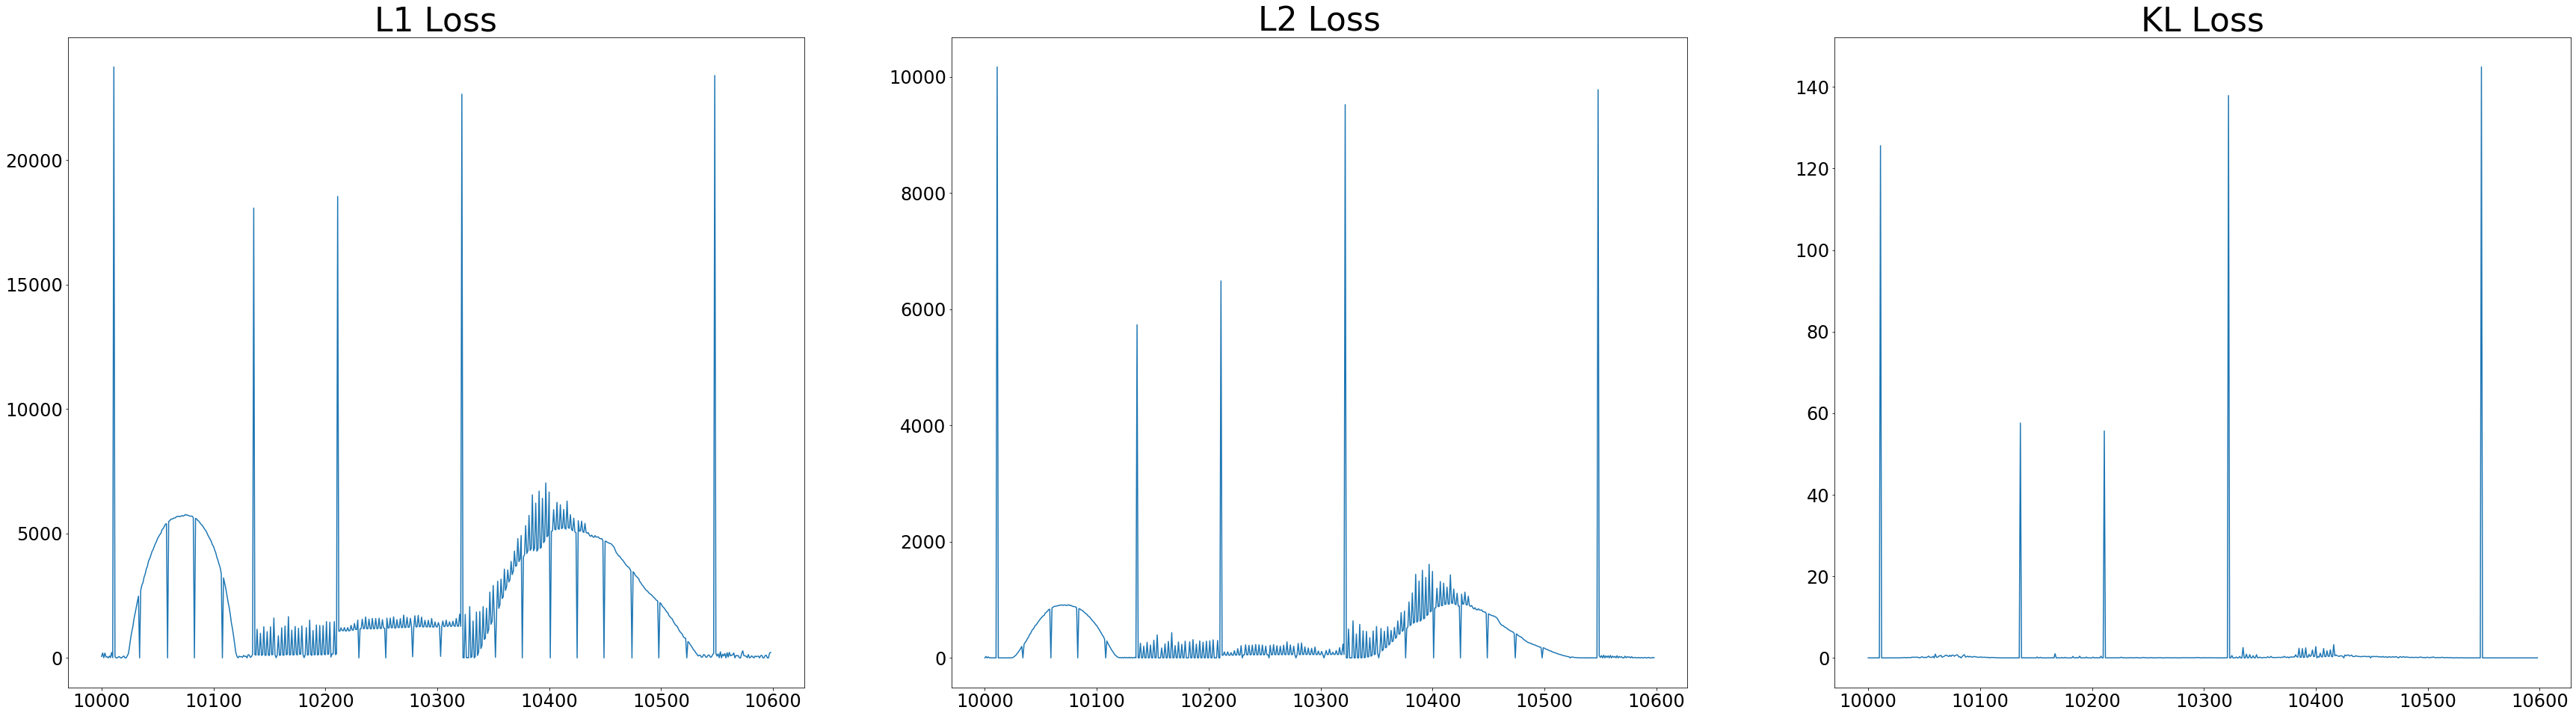

In [240]:
f, exes = plt.subplots(1,3, figsize=(60,16))
exes[0].tick_params(axis="x", labelsize=24)
exes[1].tick_params(axis="x", labelsize=24)
exes[2].tick_params(axis="x", labelsize=24)
exes[0].tick_params(axis="y", labelsize=24)
exes[1].tick_params(axis="y", labelsize=24)
exes[2].tick_params(axis="y", labelsize=24)

exes[0].plot(indices[:-1], df['L1 loss'])
exes[0].set_title("L1 Loss", fontsize=44)
exes[1].plot(indices[:-1], df['L2 loss'])
exes[1].set_title("L2 Loss", fontsize=44)
exes[2].plot(indices[:-1], df['KL loss'])
exes[2].set_title("KL Loss", fontsize=44)
plt.savefig("./images/kl-plot.png")

In [213]:
# labels = list(df['name'])
# f, ax = plt.subplots(1, 1, figsize=(20, 15))
# ax.set_yticklabels(labels)
# w = 0.2
# x = list(range((len(labels))))
# ax.barh([i-2*w for i in x], df['L1 loss'], height=w, label='L1 Loss')
# ax.barh([i-w for i in x], df['L2 loss'], height=w, label='L1 Loss')
# ax.barh([i for i in x], df['KL loss'], height=w, label='L1 Loss')

In [247]:
df.iloc[548]

L1 loss                    23389.6
L2 loss                    9774.74
KL loss                    144.884
name       image 548 v.s image 549
Name: 548, dtype: object

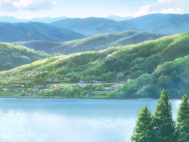

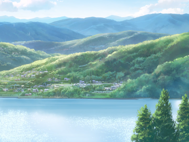

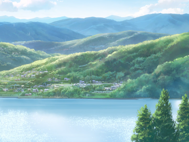

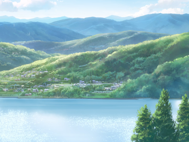

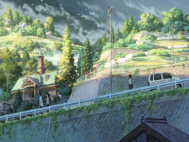

In [246]:
for i in range(545, 550):
    Display(your_name_dataset[sample_indices[i]][0])

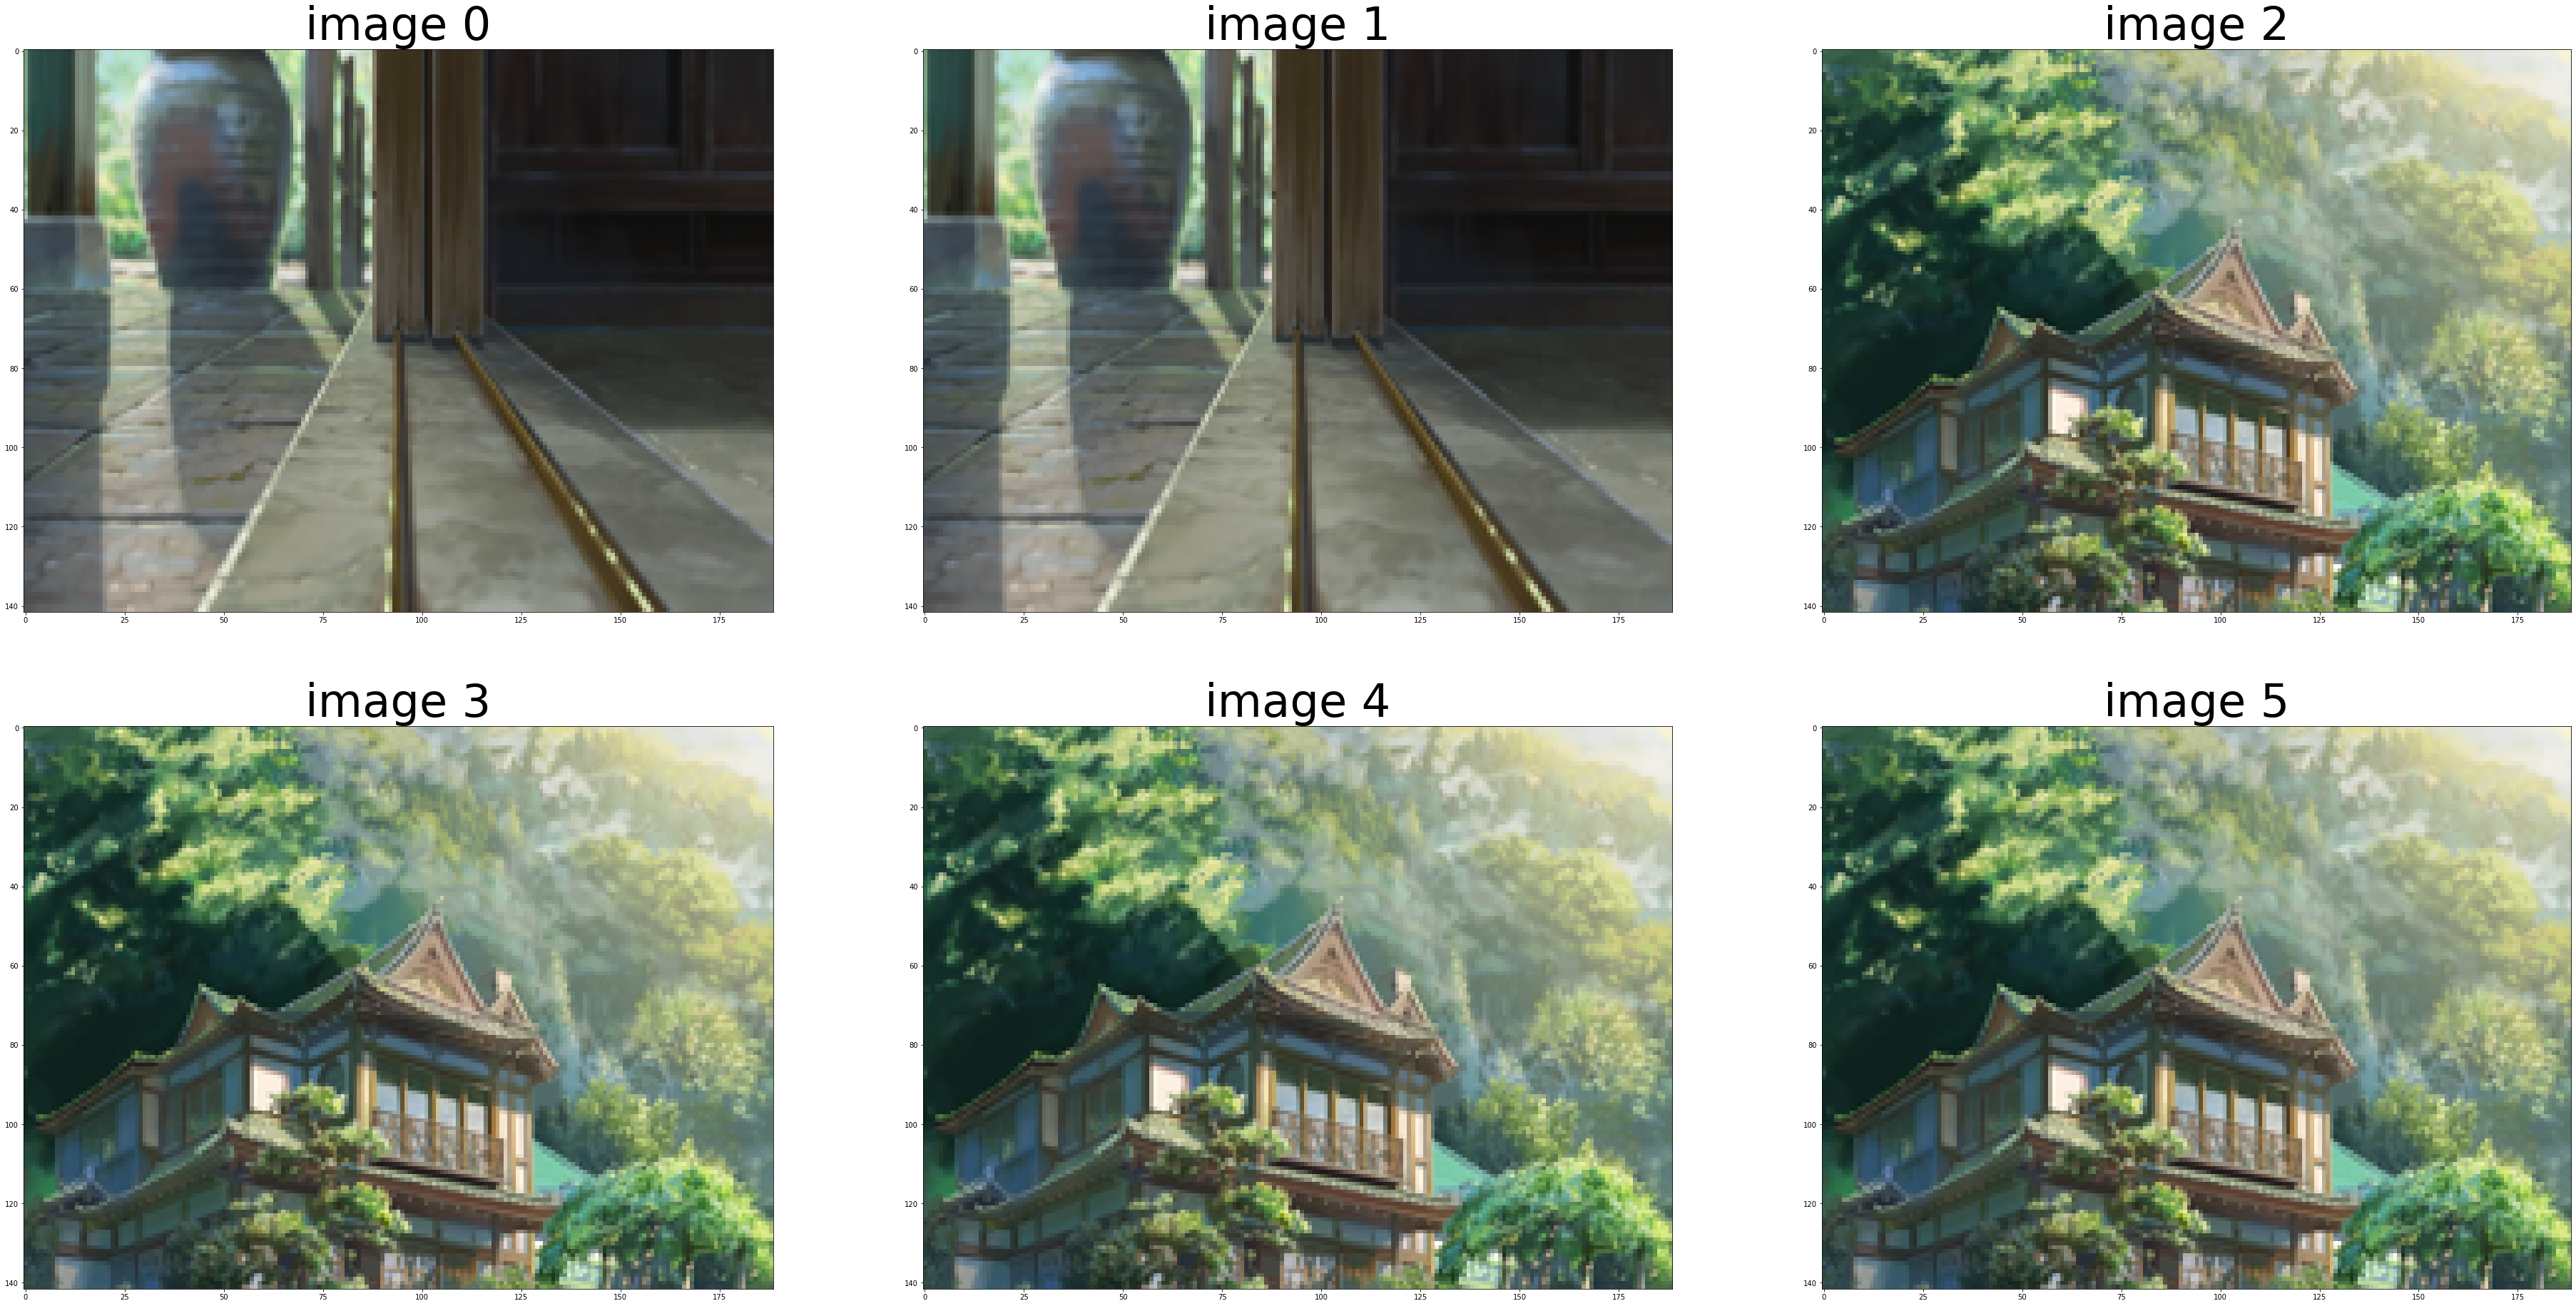

In [216]:
f, axes = plt.subplots(2,3, figsize=(64,32))
for i in range(6):
    axes[i//3][i%3].imshow(transforms.ToPILImage()(data[i].cpu()).convert("RGB"))
    axes[i//3][i%3].set_title(f"image {i}", fontsize=64)
plt.show()
f.savefig("./images/5-sequence-image.png")